# Measuring Dave Portnoy's Pizza Review Consistency (2016-2023)
Since 2013, Dave Portnoy has reviewed nearly 2,000 pizzerias where, after "one bite", he gives a score from 0-10. These reviews are extremely popular, often receiving hundreds of thousands of views. They also make a significant business impact, where high scores have repeatedly helped pizzerias gain press and more customers.  

The goal of this study is exploring whether Dave's scoring has changed over time. To complete this study, I used pizza score data from the One Bite App. Using two python scripts, I collected a sample of Dave's scores between 2016 and 2023. Then, I combined his scores with the pizzeria's corresponding "Community Score" to so I can compare Dave's average score's change with a benchmark.


In [1]:
#IMPORTS
import seaborn as sns
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from scipy.stats import variation  
import statsmodels.api as sm
from statsmodels.formula.api import ols



### Step 1: Collect Data
In this step, I import and prepare two key datasets - all Pizza Reviews (reviews) and a randomly sampled dataset (reviews_by_type), which is used for the third analysis.

In [35]:
#Import Score Dataset, add month, year & filter for just years with >100 reviews. n=1410
reviews = pd.read_csv('pizza_community_scores_final.csv')
reviews['Date'] = pd.to_datetime(reviews['Date'])
reviews['Year'] = reviews['Date'].dt.year
reviews['Month'] = reviews['Date'].dt.month
reviews['Year_Month'] = reviews['Date'].dt.strftime('%Y-%m')
reviews = reviews[(reviews['Year']>=2016) & (reviews['Year']<2024)]

#Import the randomly sampled, labelled, csv
reviews_by_type = pd.read_csv('randomly_sampled_reviews.csv')
reviews_by_type['Date'] = pd.to_datetime(reviews_by_type['Date'])
reviews_by_type['Pizza Attributes'] = reviews_by_type['Pizza Attributes'].str.split(',')
reviews_by_type['Year'] = pd.to_datetime(reviews_by_type['Year'], format='%Y')

#Pizza Types:
neopolitan_reviews = reviews_by_type[reviews_by_type['Pizza Type'] == 'Neopolitan']
football_pizza_reviews = reviews_by_type[reviews_by_type['Pizza Type'] == 'Football Pizza']
new_york_style_reviews = reviews_by_type[reviews_by_type['Pizza Type'] == 'New York Style']

#Pre/Post 2020 datasets
pre_2020_reviews = reviews[reviews['Year'] < 2020]
post_2020_reviews = reviews[reviews['Year'] >= 2020]


In [70]:
#Key functions used
def trend_line(data, score):
    x = mdates.date2num(data['Date'])
    y = score

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)   

    return [x,y,z,p(x)]

sns.set_theme()


### Analysis 1: Descriptive Statistics
We begin by understanding Dave's overall scoring statistics. Here we compare Dave Score's descriptive statistics with the Community Score's. 

Observations:
- Dave's overall average score is lower than the Community's (7.09 v. 7.39).
- However, Dave's scores have a higher standard deviation, suggesting more variance in his scores than the community.

In [13]:
reviews['Dave Score'].describe()

count    1410.000000
mean        7.091844
std         1.223596
min         0.000000
25%         6.800000
50%         7.300000
75%         7.800000
max         9.400000
Name: Dave Score, dtype: float64

In [14]:
reviews['Community Score'].describe()

count    1410.000000
mean        7.386525
std         0.833943
min         1.400000
25%         7.000000
50%         7.500000
75%         8.000000
max         9.100000
Name: Community Score, dtype: float64

In [128]:
print(pre_2020_reviews['Dave Score'].mode)
print(pre_2020_reviews['Dave Score'].var())
pre_2020_reviews['Dave Score'].describe()


<bound method Series.mode of 921     6.7
922     6.8
923     7.2
924     7.5
925     7.5
       ... 
1532    5.9
1533    8.6
1534    8.2
1535    5.8
1536    7.8
Name: Dave Score, Length: 606, dtype: float64>
2.4574682104574093


count    606.000000
mean       6.816337
std        1.567631
min        0.000000
25%        6.325000
50%        7.200000
75%        7.800000
max        9.400000
Name: Dave Score, dtype: float64

In [127]:
#print(post_2020_reviews['Dave Score'].mode)
print(post_2020_reviews['Dave Score'].var())
post_2020_reviews['Dave Score'].describe()


0.6750931519240657


count    804.000000
mean       7.299502
std        0.821641
min        1.800000
25%        7.100000
50%        7.400000
75%        7.800000
max        9.400000
Name: Dave Score, dtype: float64

### Analysis 1: How have Scores changed overtime?
Specifically, I want figure out whether Dave's scores have, on average, changed over time. To accomplish this, I complete a basic time-series analysis where I plot the annual mean pizza score from 2016-2023. To study the variation, which is a key determinant in consistency (low variance suggests higher consistency), 


In [101]:
#AVERAGES

#Year
mean_review_by_year = pd.pivot_table(reviews, values=['Dave Score', 'Community Score'], index='Year', aggfunc='mean')
std_review_by_year = pd.pivot_table(reviews, values=['Dave Score', 'Community Score'], index='Year', aggfunc='std')

#Month
mean_review_by_month = pd.pivot_table(reviews, values=['Dave Score', 'Community Score'], index='Year_Month', aggfunc='mean')
std_review_by_month = pd.pivot_table(reviews, values=['Dave Score', 'Community Score'], index='Year_Month', aggfunc='std')


# MEDIANS
median_review_by_year = pd.pivot_table(reviews, values=['Dave Score', 'Community Score'], index='Year', aggfunc='median') 
median_review_by_month = pd.pivot_table(reviews, values=['Dave Score', 'Community Score'], index='Year_Month', aggfunc='median')


In [113]:
mean_review_by_year

,Community Score,Dave Score
Year,,
2016-01-01,6.932143,6.450000
2017-01-01,6.968421,6.587500
2018-01-01,7.093820,6.821910
2019-01-01,7.365000,7.063182
2020-01-01,7.503012,7.290361
2021-01-01,7.500000,7.242857
2022-01-01,7.632367,7.320290
2023-01-01,7.618636,7.339545


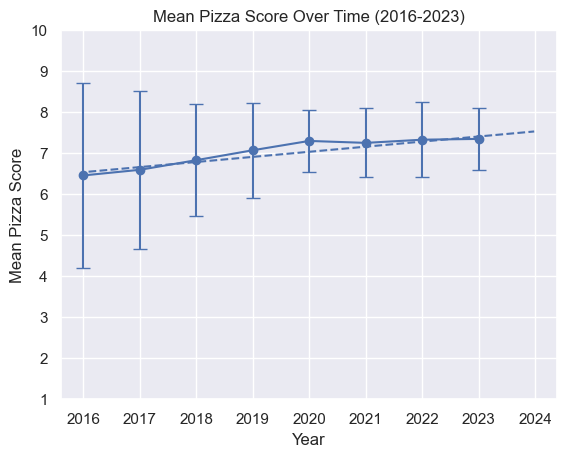

In [110]:
#PLOT 1A: ANNUAL AVERAGE SCORE (DAVE)
# Convert years to datetime for consistent plotting
mean_review_by_year.index = pd.to_datetime(mean_review_by_year.index, format='%Y')
std_review_by_year.index = pd.to_datetime(std_review_by_year.index, format='%Y')

# Plot error bars
plt.errorbar(mean_review_by_year.index, mean_review_by_year['Dave Score'], yerr=std_review_by_year['Dave Score'], fmt='-o', capsize=5)

# Plot trendline
trend_data = trend_line(reviews, reviews['Dave Score'])
plt.plot(mdates.num2date(trend_data[0]), trend_data[3], "b--")

plt.xlabel("Year")
plt.ylabel("Mean Pizza Score")
plt.title('Mean Pizza Score Over Time (2016-2023)')
#plt.xlim(min(reviews['Date']), max(reviews['Date']))
plt.ylim((1, 10))
plt.grid(True)
plt.show()

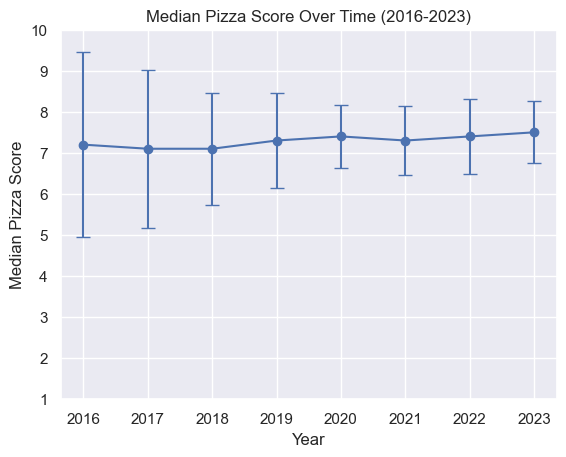

In [111]:
#PLOT 1B: ANNUAL MEDIAN SCORE (DAVE)
# Convert years to datetime for consistent plotting
median_review_by_year.index = pd.to_datetime(mean_review_by_year.index, format='%Y')
std_review_by_year.index = pd.to_datetime(std_review_by_year.index, format='%Y')

# Plot error bars
plt.errorbar(median_review_by_year.index, median_review_by_year['Dave Score'], yerr=std_review_by_year['Dave Score'], fmt='-o', capsize=5)

# Plot trendline
#trend_data = trend_line(reviews, reviews['Dave Score'])
#plt.plot(mdates.num2date(trend_data[0]), trend_data[3], "b--")

plt.xlabel("Year")
plt.ylabel("Median Pizza Score")
plt.title('Median Pizza Score Over Time (2016-2023)')
#plt.xlim(min(reviews['Date']), max(reviews['Date']))
plt.ylim((1, 10))
plt.grid(True)
plt.show()

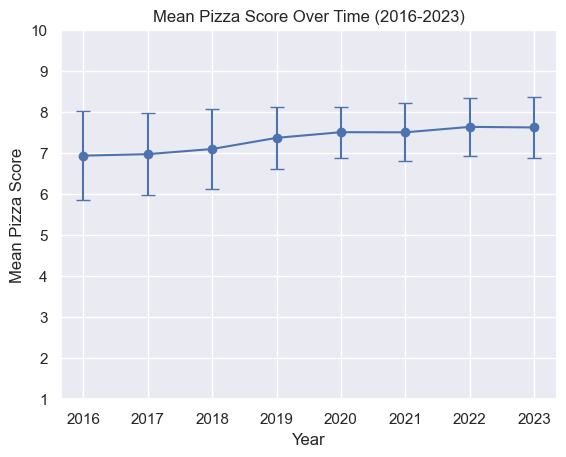

In [109]:
#PLOT 1C: ANNUAL MEDIAN SCORE (DAVE)
# Convert years to datetime for consistent plotting
mean_review_by_year.index = pd.to_datetime(mean_review_by_year.index, format='%Y')
std_review_by_year.index = pd.to_datetime(std_review_by_year.index, format='%Y')

# Plot error bars
plt.errorbar(mean_review_by_year.index, mean_review_by_year['Community Score'], yerr=std_review_by_year['Community Score'], fmt='-o', capsize=5)

# Plot trendline
#trend_data = trend_line(reviews, reviews['Dave Score'])
#plt.plot(mdates.num2date(trend_data[0]), trend_data[3], "b--")

plt.xlabel("Year")
plt.ylabel("Mean Pizza Score")
plt.title('Mean Pizza Score Over Time (2016-2023)')
#plt.xlim(min(reviews['Date']), max(reviews['Date']))
plt.ylim((1, 10))
plt.grid(True)
plt.show()

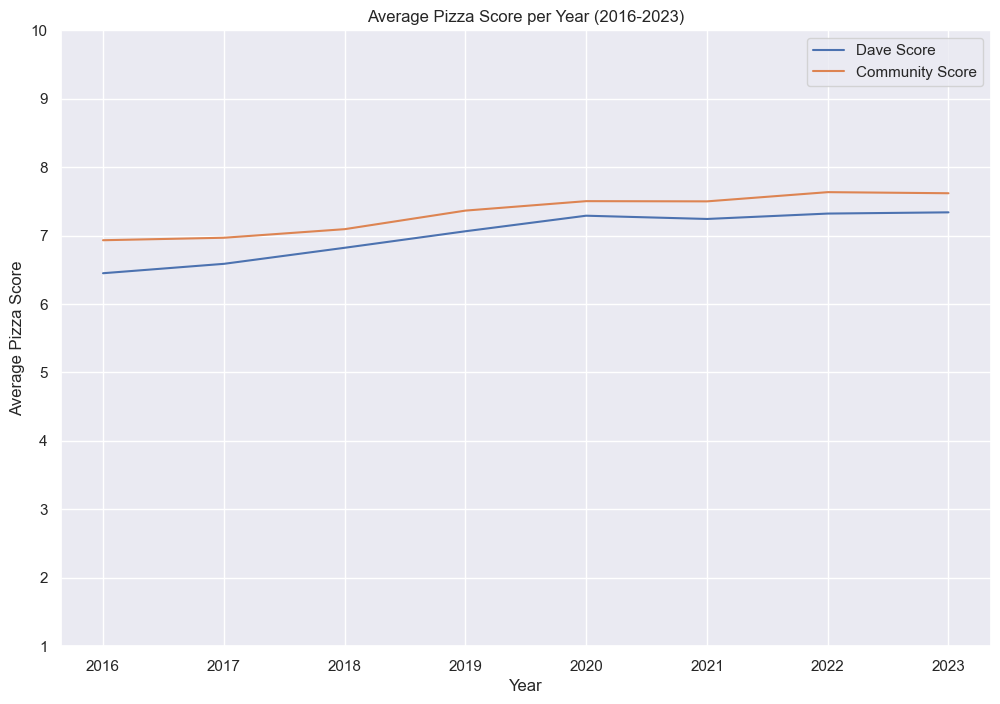

In [98]:
#PLOT 2A: AVERAGE COMPARISON

plt.figure(figsize=(12,8))

ax = sns.lineplot(data=mean_review_by_year, x='Year', y='Dave Score', label='Dave Score')
sns.lineplot(data=mean_review_by_year, x='Year', y='Community Score', ax=ax, label='Community Score')

plt.xlabel("Year")
plt.ylabel("Average Pizza Score")
plt.title('Average Pizza Score per Year (2016-2023)')
plt.ylim((1, 10))
plt.grid(True)
plt.show()

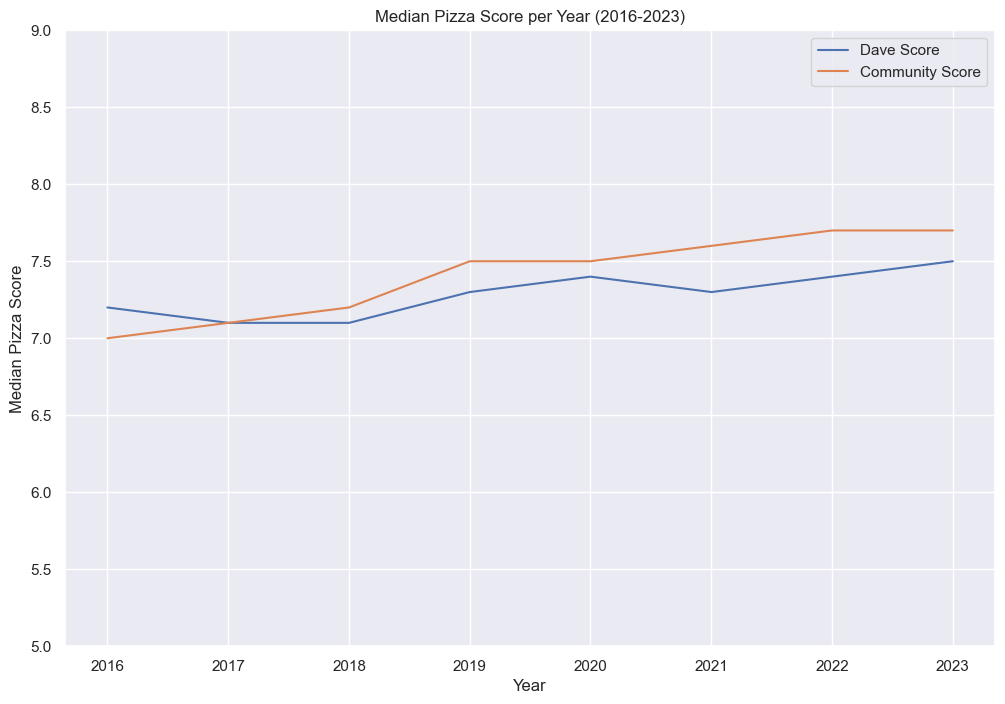

In [106]:
#PLOT 2B: MEDIAN COMPARISON

plt.figure(figsize=(12,8))

ax = sns.lineplot(data=median_review_by_year, x='Year', y='Dave Score', label='Dave Score')
sns.lineplot(data=median_review_by_year, x='Year', y='Community Score', ax=ax, label='Community Score')

plt.xlabel("Year")
plt.ylabel("Median Pizza Score")
plt.title('Median Pizza Score per Year (2016-2023)')
plt.ylim((5, 9))
plt.grid(True)
plt.show()

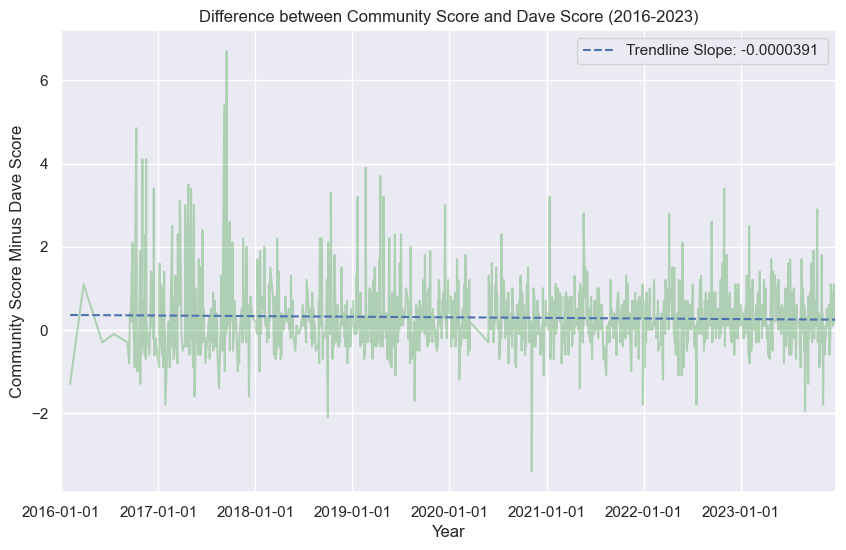

In [93]:
reviews = reviews.sort_values(by='Year_Month', ascending=True)
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=reviews, x='Date', y='Score Diffrence', alpha=0.25, color='green', errorbar=None)

trend_data = trend_line(reviews, reviews['Score Diffrence'])
slope = trend_data[2][0]
plt.plot(mdates.num2date(trend_data[0]), trend_data[3], "b--", alpha=1.0, label="Trendline Slope: -0.0000391")

ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax.margins(x=0)
ax.set_xticks(ax.get_xticks()[::1])
plt.xlabel("Year")
plt.ylabel("Community Score Minus Dave Score")
plt.title('Difference between Community Score and Dave Score (2016-2023)')
plt.legend()
plt.show()

-5.6263186721518326e-05


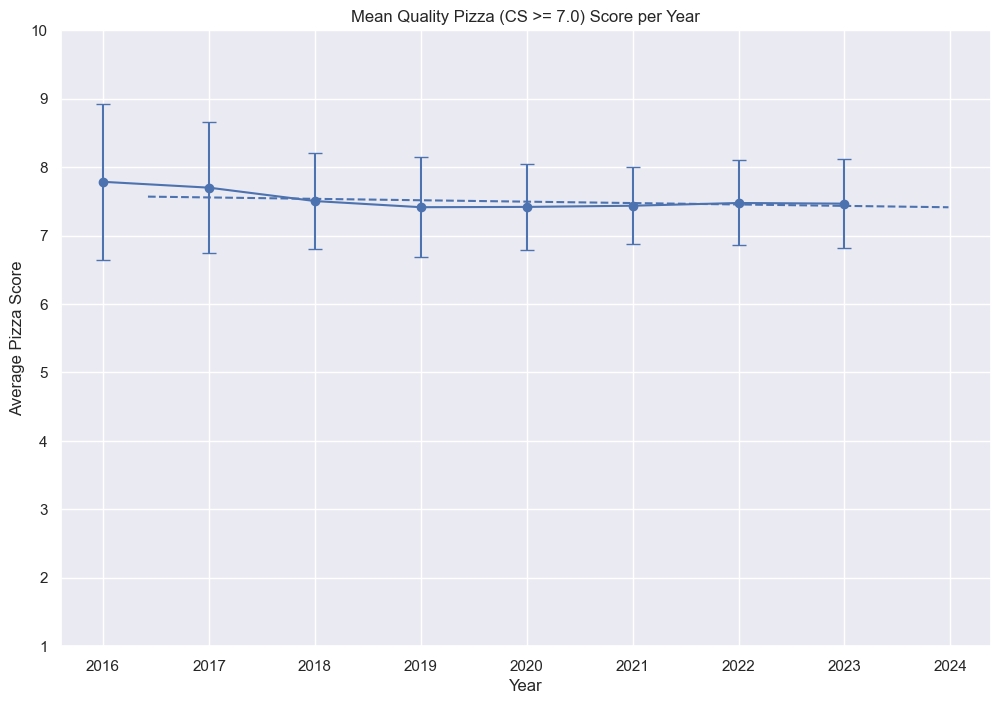

In [134]:
high_quality_reviews = reviews[reviews['Community Score']>=7.0]
#Year
mean_quality_review_by_year = pd.pivot_table(high_quality_reviews, values=['Dave Score', 'Community Score'], index='Year', aggfunc='mean')
std_quality_review_by_year = pd.pivot_table(high_quality_reviews, values=['Dave Score', 'Community Score'], index='Year', aggfunc='std')

plt.figure(figsize=(12,8))

#PLOT 1A: ANNUAL AVERAGE SCORE (DAVE)
# Convert years to datetime for consistent plotting
mean_quality_review_by_year.index = pd.to_datetime(mean_quality_review_by_year.index, format='%Y')
std_quality_review_by_year.index = pd.to_datetime(std_quality_review_by_year.index, format='%Y')

# Plot error bars
plt.errorbar(mean_quality_review_by_year.index, mean_quality_review_by_year['Dave Score'], yerr=std_quality_review_by_year['Dave Score'], fmt='-o', capsize=5)

# Plot trendline
trend_data = trend_line(high_quality_reviews, high_quality_reviews['Dave Score'])
plt.plot(mdates.num2date(trend_data[0]), trend_data[3], "b--",label="Trendline Slope: -0.0000562")

slope = trend_data[2][0]
print(slope)

plt.xlabel("Year")
plt.ylabel("Average Pizza Score")
plt.title('Mean Quality Pizza (CS >= 7.0) Score per Year')
#plt.xlim(min(reviews['Date']), max(reviews['Date']))
plt.ylim((1, 10))
plt.grid(True)
plt.show()



### Analysis 2: Has review location changed over time & What is its impact?
In this analysis, I focus on understanding how the location of reviews has changed over time to try and understand the mean & variance difference between 2016-2019 and 2020-2023. To accomplish this, I created a stacked barchot plotting the count of reviews by state each year. Then I plotted the annual state averages compared to the total annual averages.

In [99]:
#Key Data

#These states will have their own bar chart. The rest will be merged into an 'Other' category to keep the plot clean.
specified_states = [' NY', ' CT', ' FL', ' IL', ' MA', ' NJ']

#these are not states or regions
reviews = reviews[(reviews['State'] != ' XGL') & (reviews['State'] != ' WNM') & (reviews['State'] != ' null')]
reviews['State_Grouped'] = reviews['State'].apply(lambda x: x if x in specified_states else 'Other')
review_count_by_state_per_year = pd.pivot_table(reviews, values='Name', index='Year', columns='State_Grouped', aggfunc='count', fill_value=0)

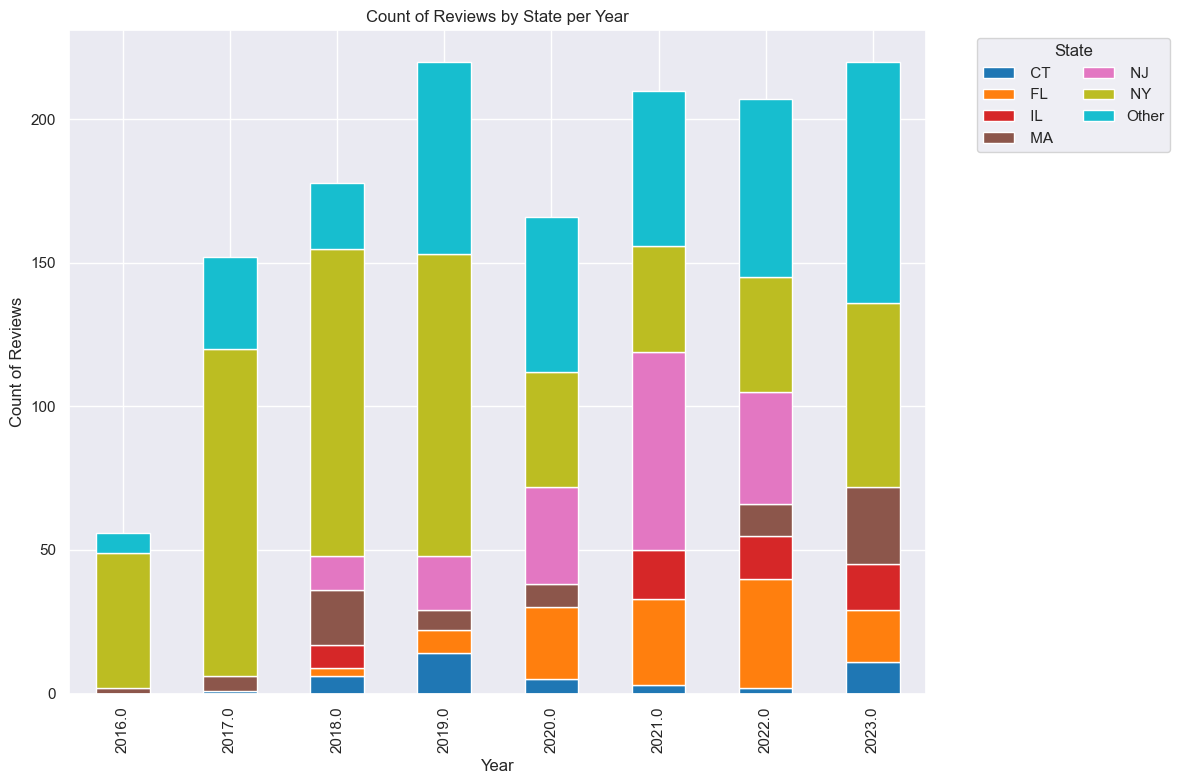

In [112]:
colors = plt.get_cmap('tab10', len(review_count_by_state_per_year.columns))
ax = review_count_by_state_per_year.plot(kind='bar', stacked=True, figsize=(12, 8), color=[colors(i) for i in range(len(review_count_by_state_per_year.columns))])
plt.title('Count of Reviews by State per Year')
plt.xlabel('Year')
plt.ylabel('Count of Reviews')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)  # Adjusted legend position and columns
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
#ANOVA Test
anova = ols('Score ~ C(State)', data=reviews).fit()
anova_table = sm.stats.anova_lm(anova, typ=2)

print(anova_table)

               sum_sq      df         F        PR(>F)
C(State)   261.824712    36.0  3.657863  3.306177e-12
Residual  3129.575562  1574.0       NaN           NaN
